[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/Chapter_5_Three_Simple_Models_of_Neurons_in_Rodent_Brains/Erisir_Model/Erisir_Model.ipynb)

# Chapter 5 Erisir Model
#### by Matthew Stroud and Gregory Glickert

This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

requirements:

 bmtk

 NEURON 7.4+

### Erisir cell dynamics

Voltage and Gating Variables:

$C \frac{dV_{m}}{dt} = -\bar{g}_{K}n^4(V_{m} - V_{K}) - \bar{g}_{Na}m^3h(V_{m} - V_{Na}) - \bar{g}_{l}(V_{m} - V_{l}) + I$

$\frac{dn}{dt} = \alpha_{n}(V_{m})(1-n) - \beta_n(V_m)n$

$\frac{dm}{dt} = \alpha_{m}(V_{m})(1-m) - \beta_m(V_m)m$

$\frac{dh}{dt} = \alpha_{h}(V_{m})(1-h) - \beta_h(V_m)h$


Erisir Cell Specific Properties

$\alpha_{n} = (95-v)./(e^{(95-v)/11.8}-1)$

$\beta_{n} = 0.025./e^{v/22.222}$

$\alpha_{m} = 40*(75.5-v)./(e^{(75.5-v)/13.5}-1)$

$\beta_{m} = 1.2262./e^{v/42.248}$

$\alpha_{h} = 0.0035./e^{v/24.186}$

$\beta_{h} = -0.017*(v+51.25)./(e^{-(v+51.25)/5.2}-1)$


## Plotting gating variables
Each equation was pulled from the na_rtm.mod and k_rtm.mod files. (Under components\\mechanisms)

These files describe sodium and potassium channel dynamics. The m and h gates are activation and inactivation gate variables respectively for the sodium channel. The n gate variable describes the potassium activation dynamics.

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null
  %pip install h5py==2.9.0 &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = 'Chapter_5_Three_Simple_Models_of_Neurons_in_Rodent_Brains/Erisir_Model'
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/Borgers-Examples-in-BMTK/Chapter_5_Three_Simple_Models_of_Neurons_in_Rodent_Brains/Erisir_Model
Mod files: "components/mechanisms/components/mechanisms/k_er.mod" "components/mechanisms/components/mechanisms/k_rtm.mod" "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_er.mod" "components/mechanisms/components/mechanisms/na_rtm.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
0


/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [2]:
import math

Voltage= []
minf = []
hinf = []
ninf = []
for i in range(150):
    Voltage.append(i-100)

for v in Voltage:
    ninf.append(1.0/(1.0+(math.exp((v+1.57)/(-8.38)))))
    minf.append(1.0/(1.0+(math.exp((v+25.58)/(-11.4)))))
    hinf.append(1.0/(1.0+(math.exp((v+58.25)/(6.46)))))

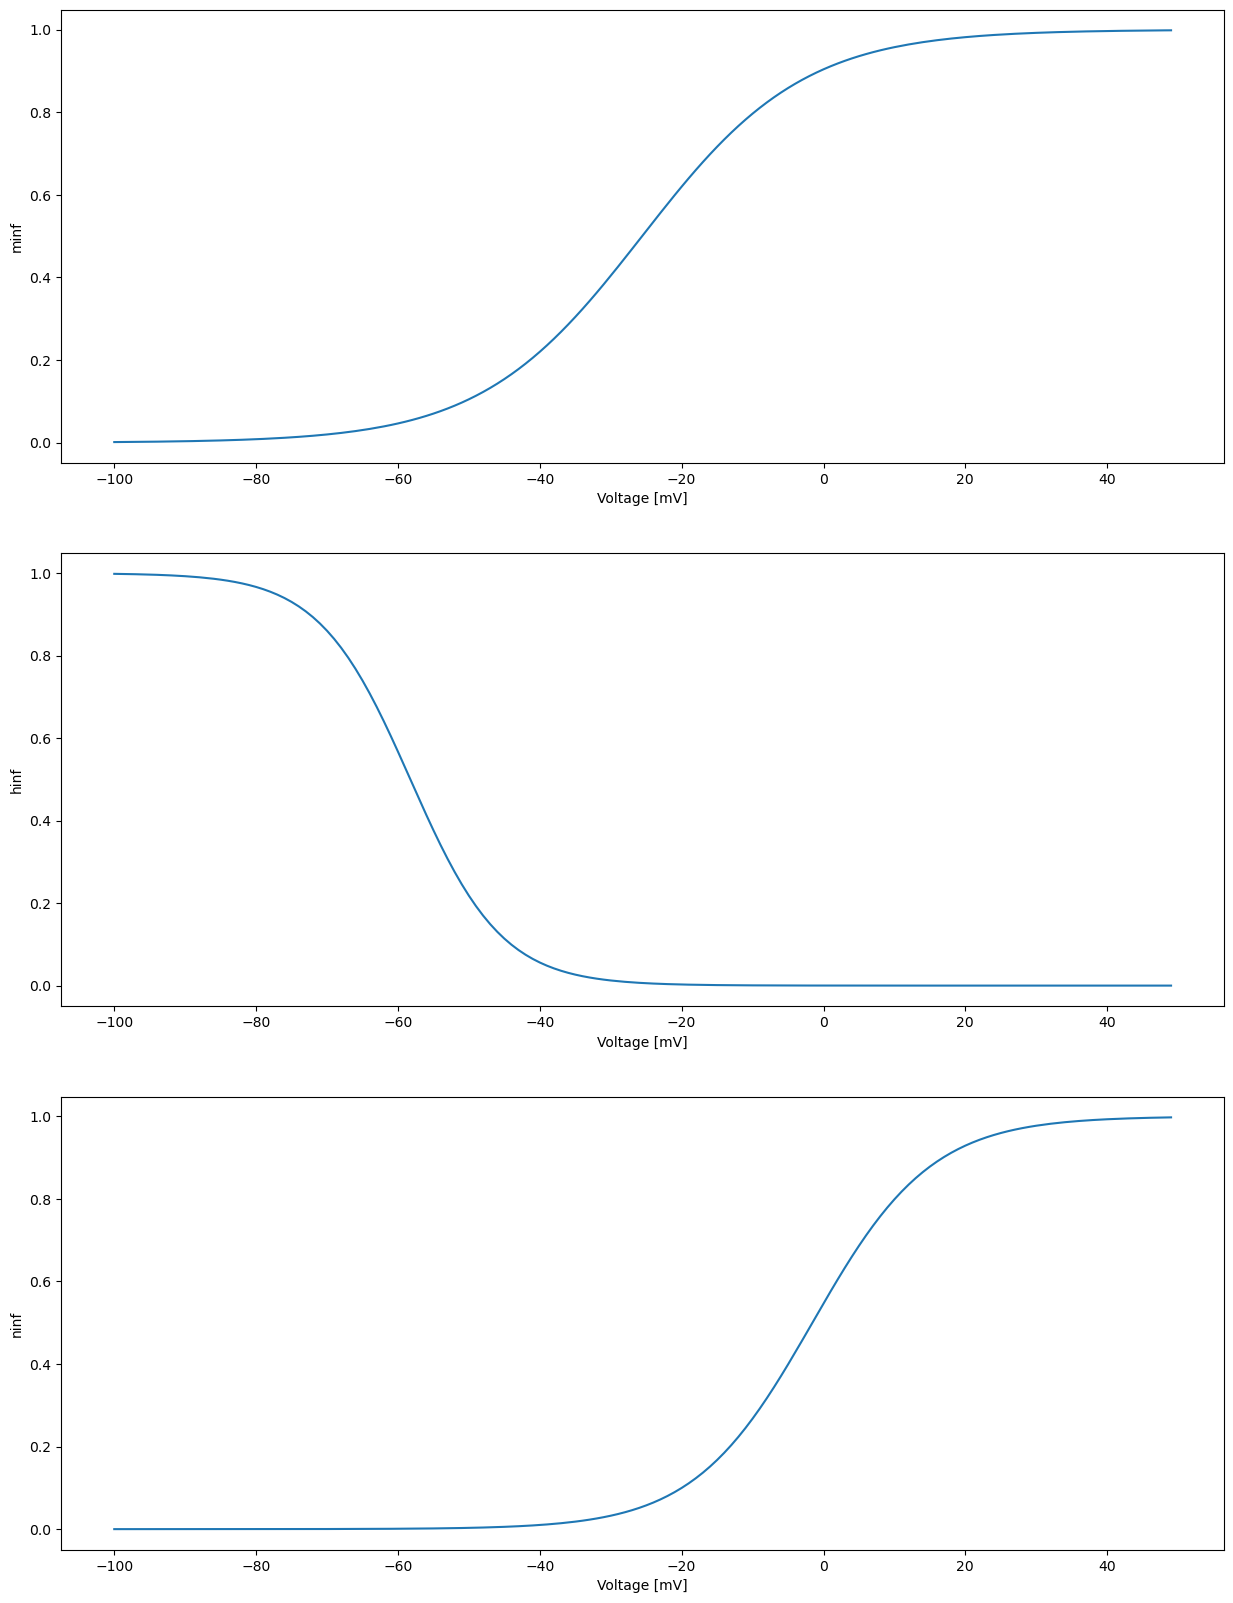

In [3]:
import matplotlib.pyplot as plt


fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

ax1.plot(Voltage, minf)
ax1.set_xlabel('Voltage [mV]')
ax1.set_ylabel('minf')

ax2.plot(Voltage, hinf)
ax2.set_xlabel('Voltage [mV]')
ax2.set_ylabel('hinf')

ax3.plot(Voltage, ninf)
ax3.set_xlabel('Voltage [mV]')
ax3.set_ylabel('ninf')


fig = plt.gcf()
fig.set_size_inches(15, 20)  # increase plot size

#If the plot does not appear run the cell again

# Erisir Cell Simulation
##### We are now going to build an Erisir neuron and place a current clamp on it using a python toolkit: bmtk.
    
### Building the Cell

In [4]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =1    # We are creating only 1 Erisir cell

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:ErisirCell', # Erisir hoc definition
        morphology='blank.swc')

### Saving the Cell

In [5]:
net.build()
net.save_nodes(output_dir='network')

### Build the Simulation Environment
This next cell takes our saved features that we just made and creates simulation_config.json and circuit_config.json files. 

From these we can run our simulation (these files are already created so you don't need to run it).

In [7]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=100.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                  current_clamp={          
                        'amp': 11.7,
                        'delay': 0,
                        'duration': 100.0
                    },
                 v_init=-67.7,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json',
                 overwrite_config=True
                )

### Run the Simulation

In [8]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2025-01-24 11:51:55,040 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/Chapter_5_Three_Simple_Models_of_Neurons_in_Rodent_Brains/Erisir_Model/components/mechanisms.
2025-01-24 11:51:55,087 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 11:51:55,089 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 11:51:55,094 [INFO] Running simulation for 100.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 100.000 ms with the time step 0.100 ms


2025-01-24 11:51:55,095 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 11:51:55,095 [INFO] Block save every 1000 steps


INFO:NEURONIOUtils:Block save every 1000 steps


2025-01-24 11:51:55,118 [INFO]     step:1000 t_sim:100.00 ms


INFO:NEURONIOUtils:    step:1000 t_sim:100.00 ms


2025-01-24 11:51:55,124 [INFO] Simulation completed in 0.03088 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.03088 seconds 


### Display Results

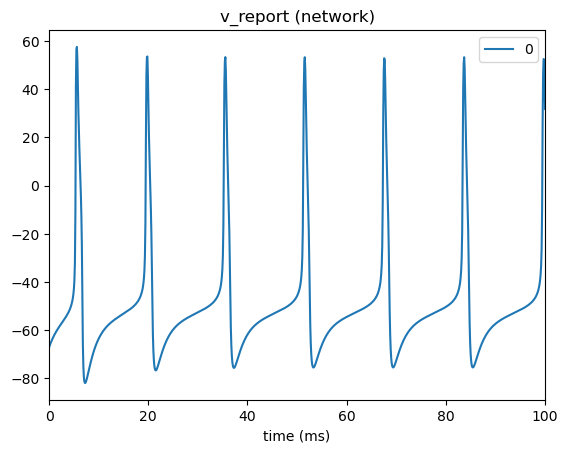

In [9]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='config.json', node_ids=[0], report_name='v_report')

Note: The Erisir Model spikes much higher than the WB or RTM models